## Scraping Instagram

https://github.com/althonos/InstaLooter <br/>
https://instalooter.readthedocs.io/en/latest/usage.html#time 

pip install --user instalooter --pre <br/>
python -m instalooter login <br/>
python -m instalooter user natgeo <destination_folder> -n 1000 -v -d -m

## Reading .json file to get a dataframe with required metrics

**Folder structure** - <br/>
FolderX/this_script <br/>
FolderX/Insta_natgeo1 <br/>

Insta_natgeo1 has all the images and .json objects

In [535]:
import json
from pprint import pprint
import pandas as pd
from os import listdir
from os.path import isfile, join
import string


mypath = "Insta_natgeo1" #path of the folder with images and .json files

onlyfiles = [f for f in listdir(mypath) if ((isfile(join(mypath, f))) & (f[-4:]=='json'))]
onlyfiles.reverse()  #list of all the .json files 
meta_data = pd.DataFrame(columns = ['id_image','caption','num_likes','num_comments']) #Create a blank folder to store the information

#Reading the parts of .json file to populate the dataframe 
for fl in onlyfiles:
    with open((mypath+'/'+str(fl)), encoding="utf8") as f:
        data = json.load(f)
    
    id_image = data['id'] 
    caption = data['edge_media_to_caption']['edges'][0]['node']['text']
    num_likes = data['edge_media_preview_like']['count']
    num_comments = data['edge_media_to_comment']['count']

    meta_data = meta_data.append({'id_image':id_image,'caption': caption, 'num_likes':num_likes, 'num_comments':num_comments},ignore_index=True)

meta_data.head()

,id_image,caption,num_likes,num_comments
0,1981399443030738687,Photo by @gabrielegalimbertiphoto | Michael Ch...,98439,583
1,1980599326570032905,Photo by @jimmychin | Rule #1 for a big day in...,416522,1213
2,1980506709442276709,Photo by @CristinaMittermeier | A young girl p...,236554,945
3,1980429175895768953,"Photo by @TimLaman | “It’s ok, buddy, we’re pe...",842112,5283
4,1980332447939109605,Photo by @BrianSkerry | Happy World Whale Day!...,464799,1528


In [536]:
# meta_data['caption'][213]
# meta_data['caption'][480]

#Dropping these rows because they dont have the standard caption format - creates problem later
meta_data = meta_data.drop([213,480,938])

In [537]:
#Normalize likes and comments and create the engagement score
norm_likes = (meta_data['num_likes']-meta_data['num_likes'].mean())/meta_data['num_likes'].std()
norm_comments = (meta_data['num_comments']-meta_data['num_comments'].mean())/meta_data['num_comments'].std()
meta_data['Engagement_score'] = 0.4*norm_likes + 0.6*norm_comments

#Cleaning the captions
import re
#Removing the standard beginning 'Photo by @xyz |' from all captions
meta_data['text'] = meta_data['caption'].apply(lambda x: re.findall('@\w*\s?[\|//]?\s?(.*)',x)[0])

#Create a flag if the media is photo or a video: Photo =1 and Video = 0
meta_data['photo'] = meta_data['caption'].apply(lambda x: len(re.findall('Photos? by',x)))

#Removing the '#' from all captions - trying to read hashtags as normal text
meta_data['text'] = meta_data['text'].apply(lambda x: x.replace('#',''))

#Create a separate column. For each row, it is a list of all the hashtags mentioned
meta_data['hashtags'] = meta_data['caption'].apply(lambda x: re.findall('#(\w*)\s',x))

In [538]:
meta_data.head()

,id_image,caption,num_likes,num_comments,Engagement_score,text,photo,hashtags
0,1981399443030738687,Photo by @gabrielegalimbertiphoto | Michael Ch...,98439,583,-0.63576,"Michael Chamorro Suarez, 32, Flor Valla, 33, a...",1,"[happypills, pills, pharma, bigpharma]"
1,1980599326570032905,Photo by @jimmychin | Rule #1 for a big day in...,416522,1213,-0.0753928,Rule 1 for a big day in the mountains: Plan an...,1,"[1, 2]"
2,1980506709442276709,Photo by @CristinaMittermeier | A young girl p...,236554,945,-0.381748,A young girl plays with sticks and stones in t...,1,"[FollowMe, Madagascar, Enoughness, nature]"
3,1980429175895768953,"Photo by @TimLaman | “It’s ok, buddy, we’re pe...",842112,5283,1.06456,"“It’s ok, buddy, we’re penguins. We can handle...",1,"[snowstorm, penguin, antarctica]"
4,1980332447939109605,Photo by @BrianSkerry | Happy World Whale Day!...,464799,1528,0.0361825,Happy World Whale Day! A humpback whale calf h...,1,"[whales, humpbackwhales, parenting, planetofth..."


## Build the model on captions

In [539]:
#tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(
    min_df=1,  # min count for relevant vocabulary
    max_features=4000,  # maximum number of features
    strip_accents='unicode',  # replace all accented unicode char 
    # by their corresponding  ASCII char
    analyzer='word',  # features made of words
    token_pattern=r'\w{1,}',  # tokenize only words of 4+ chars
    ngram_range=(1, 1),  # features made of a single tokens
    use_idf=True,  # enable inverse-document-frequency reweighting
    smooth_idf=True,  # prevents zero division for unseen words
    sublinear_tf=False)
X = vectorizer.fit_transform(meta_data['text']).toarray()
col_name = vectorizer.get_feature_names()

tf_idf_mat = pd.DataFrame(X, columns = col_name, dtype=None, copy=False).iloc[:,92:]
meta_data1 = pd.concat([meta_data['Engagement_score'],meta_data['photo'], tf_idf_mat], axis=1, join='inner',sort=False)
meta_data1.shape

(994, 3910)

## PCA on tf-idf
 
Attempting dimensionality reduction

Text(0.5,1,'Cumulative Variance Plot')

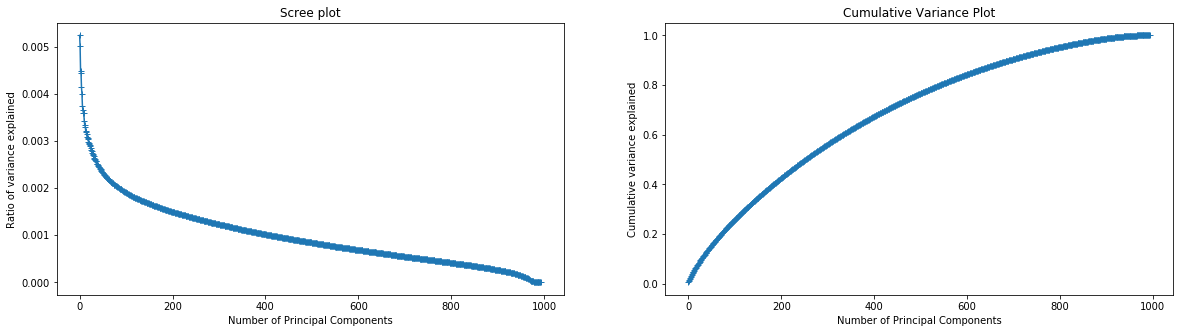

In [540]:
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
import scipy
import sklearn
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

X = meta_data1.iloc[:,1:]
y = meta_data1.iloc[:,0]

stdScaler = StandardScaler()
df_scaled = stdScaler.fit_transform(X) #transform all the variables on a astandard scale for PCA

pca = decomposition.PCA(n_components=None)
principalComponents = pca.fit_transform(df_scaled)
PC_Df = pd.DataFrame(principalComponents) #ALl datapoints on PC feature space

#Check for explained variance
scree_data = pca.explained_variance_ratio_
fig, ax = plt.subplots(1,2, figsize=(20,5))
ax[0].plot(scree_data,'+-')
ax[0].set_xlabel("Number of Principal Components")
ax[0].set_ylabel("Ratio of variance explained")
ax[0].set_title("Scree plot")

var_cumulative = pca.explained_variance_ratio_.cumsum()
ax[1].plot(var_cumulative,'+-')
ax[1].set_xlabel("Number of Principal Components")
ax[1].set_ylabel("Cumulative variance explained")
ax[1].set_title("Cumulative Variance Plot")

## Model on hashtags

In [542]:
import numpy as np
# import nltk
meta_data2 = meta_data.loc[:,['id_image','Engagement_score','photo','hashtags']]

#Creating a binary column for each hashtag
for i in meta_data.index.values:
    add_col = []
    l = [i]*len(meta_data2) 
    col_names = meta_data2.columns.values
    for tag in meta_data2.loc[i,'hashtags']:
        if tag.lower() not in col_names:
            add_col.append(tag.lower())
            meta_data2[tag.lower()] = np.where(meta_data2.reset_index()['index'] == l,1,0)
        else:
            meta_data2.loc[i,tag.lower()] = 1
    col_names = list(meta_data2.columns.values) + add_col

meta_data2.head()

,id_image,Engagement_score,photo,hashtags,happypills,pills,pharma,bigpharma,1,2,...,tree,turnthetide,amish,farm,ngari,zanda,idg2018,dayofthegirl,unicef,educategirls
0,1981399443030738687,-0.63576,1,"[happypills, pills, pharma, bigpharma]",1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1980599326570032905,-0.0753928,1,"[1, 2]",0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1980506709442276709,-0.381748,1,"[FollowMe, Madagascar, Enoughness, nature]",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1980429175895768953,1.06456,1,"[snowstorm, penguin, antarctica]",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1980332447939109605,0.0361825,1,"[whales, humpbackwhales, parenting, planetofth...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [543]:
meta_data2.iloc[:,4:].sum(axis=0).value_counts()
# meta_data2.sum(axis = 0) >
# meta_data2.shape

1     827
2     166
3      73
4      47
5      35
6      22
8      16
7       9
10      7
9       5
11      4
13      3
16      3
21      2
19      2
18      2
65      1
14      1
50      1
17      1
20      1
23      1
24      1
28      1
33      1
35      1
36      1
15      1
dtype: int64